# Temperature signal of Weather Dataset
This notebook demonstrates the process of preparing a temperature signal from the Weather Dataset and splitting it into the necessary signals for subsequent analysis.

In [1]:
#import libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.api import OLS
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose


## Prepare raw data
The observation period is limited to 1961-2020. Unnecessary columns have been deleted.

In [10]:
#read the raw data from a .txt file with a specified separator (';')
df = pd.read_csv('Weather_raw/produkt_tu_stunde_19610101_20221231_00282.txt', sep=';')

#display the first 5 rows of the dataframe
df.head()

STATIONS_ID  MESS_DATUM  QN_9  TT_TU  RF_TU  eor
0          282  1961010101     5    0.8   86.0  eor
1          282  1961010102     5    0.8   86.0  eor
2          282  1961010103     5    0.9   86.0  eor
3          282  1961010104     5    0.9   87.0  eor
4          282  1961010105     5    0.9   86.0  eor

In [11]:
#delete the unnecessary columns from the DataFrame
columns_drop = ['STATIONS_ID','QN_9','RF_TU','eor']
df = df.drop(columns_drop, axis=1)

#convert the 'MESS_DATUM' column to datetime format using the specified format
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H')

#extract year, month, and day from the 'MESS_DATUM' column and create new columns for each
df['Year'] = df['MESS_DATUM'].dt.year
df['Month'] = df['MESS_DATUM'].dt.month
df['Day'] = df['MESS_DATUM'].dt.day

df.head()

MESS_DATUM  TT_TU  Year  Month  Day
0 1961-01-01 01:00:00    0.8  1961      1    1
1 1961-01-01 02:00:00    0.8  1961      1    1
2 1961-01-01 03:00:00    0.9  1961      1    1
3 1961-01-01 04:00:00    0.9  1961      1    1
4 1961-01-01 05:00:00    0.9  1961      1    1

In [12]:
#define the condition for filtering based on the 'Year' column
condition = (df['Year'] >= 1961) & (df['Year'] <= 2020)

#apply the condition to filter the DataFrame and save results in a new filtered_df DataFrame
filtered_df = df.loc[condition]

filtered_df.head()

MESS_DATUM  TT_TU  Year  Month  Day
0 1961-01-01 01:00:00    0.8  1961      1    1
1 1961-01-01 02:00:00    0.8  1961      1    1
2 1961-01-01 03:00:00    0.9  1961      1    1
3 1961-01-01 04:00:00    0.9  1961      1    1
4 1961-01-01 05:00:00    0.9  1961      1    1

## Impute missing values:
First, check the amount and percentage of missing values. Then, use the interpolate method to impute the missing values.

In [13]:
#find missing values
missing_values_df = filtered_df[filtered_df['TT_TU'] == -999]

#print information about missing value
print(f'Anout of data points: {len(filtered_df)}')
print(f'Anounts of missing values: {len(missing_values_df)}')
print(f'Percent missing values: {len(missing_values_df) / len(filtered_df) *100}')

Anout of data points: 525813
Anounts of missing values: 130
Percent missing values: 0.024723618472726996


In [14]:
#impute missing values using interpolate method
filtered_df['TT_TU'] = filtered_df['TT_TU'].replace(-999 ,None)
filtered_df['TT_TU'].interpolate(method='linear', inplace=True)
filtered_df.head()

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_4564/2146537911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['TT_TU'] = filtered_df['TT_TU'].replace(-999 ,None)
/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_4564/2146537911.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['TT_TU'].interpolate(method='linear', inplace=True)


MESS_DATUM TT_TU  Year  Month  Day
0 1961-01-01 01:00:00   0.8  1961      1    1
1 1961-01-01 02:00:00   0.8  1961      1    1
2 1961-01-01 03:00:00   0.9  1961      1    1
3 1961-01-01 04:00:00   0.9  1961      1    1
4 1961-01-01 05:00:00   0.9  1961      1    1

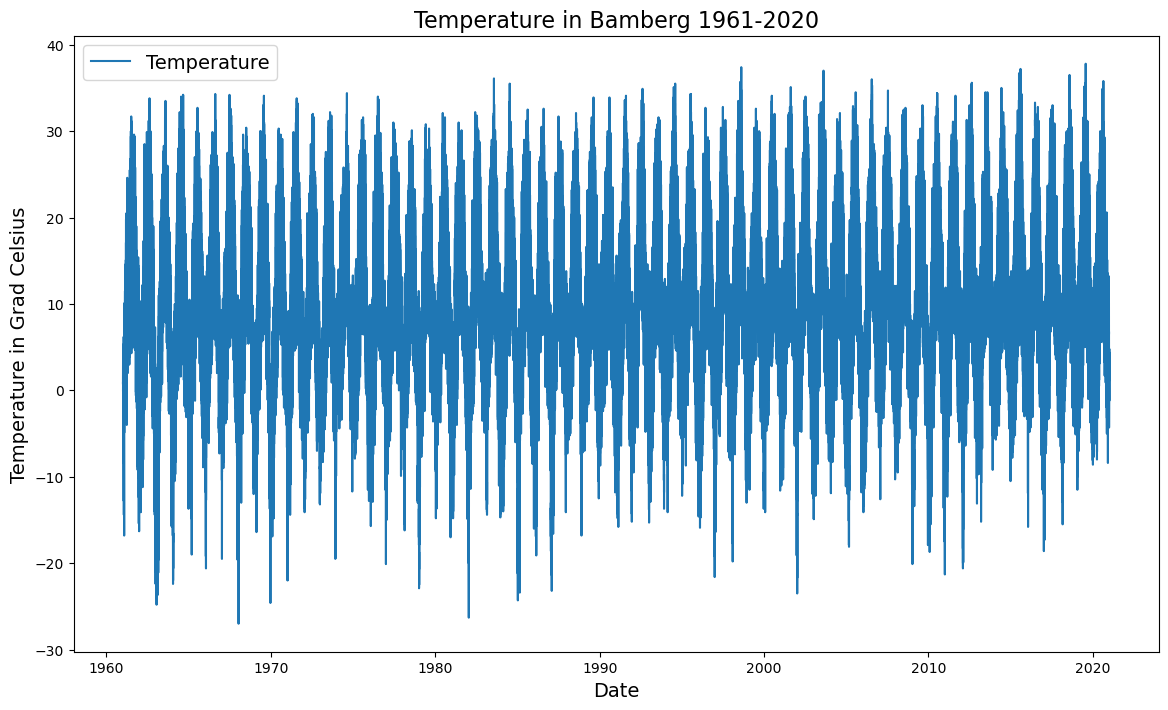

In [15]:
#set the index of 'filtered_df' to the 'MESS_DATUM' column
filtered_df.set_index('MESS_DATUM', inplace=True)

#convert the index to a datetime format
filtered_df.index = pd.to_datetime(filtered_df.index)

#plot the whole raw dataset 
plt.figure(figsize=(14, 8))
plt.plot(filtered_df.index, filtered_df['TT_TU'])

plt.legend(['Temperature'], fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Temperature in Grad Celsius',fontsize = 14)
plt.title('Temperature in Bamberg 1961-2020', fontsize = 16)
plt.show()

In [29]:
#save the information as a .csv file for the following analysis
filtered_df.to_csv('Temperature/temperature_Bamberg.csv',index=True)

## Create a daily average signals
Create a daily average signal, then split it into decades, training, and test datasets for the subsequent analysis.

In [17]:
#optional
#filtered_df = pd.read_csv('Temperature/temperature_Bamberg.csv', index_col=0, parse_dates=True)
#filtered_df.head()

Aggregate daily mean temperature.



In [18]:
#calculate the daily average temperature by grouping data by year, month, and day, and then taking the mean of 'TT_TU'
daily_avg = filtered_df.groupby(['Year', 'Month', 'Day'])['TT_TU'].mean().reset_index()

#round the 'TT_TU' values to two decimal places
daily_avg['TT_TU'] = daily_avg['TT_TU'].round(2)

#create a 'MESS_DATUM' column by combining the 'Year', 'Month', and 'Day' columns and formatting it as '%Y-%m-%d'
daily_avg['MESS_DATUM'] = pd.to_datetime(daily_avg[['Year', 'Month', 'Day']]).dt.strftime('%Y-%m-%d')

#delete the unnecessary columns from the DataFrame and rearrange the rest
column_drop = ['Year', 'Month', 'Day']
daily_avg = daily_avg.drop(column_drop, axis=1)
daily_avg = daily_avg[['MESS_DATUM', 'TT_TU']]
daily_avg.head()

MESS_DATUM  TT_TU
0  1961-01-01   0.67
1  1961-01-02   0.68
2  1961-01-03   2.73
3  1961-01-04   2.01
4  1961-01-05   2.64

In [19]:
#print a summary of DataFrame
daily_avg.describe()

TT_TU
count  21910.000000
mean       9.028757
std        7.682345
min      -20.770000
25%        3.210000
50%        9.280000
75%       15.120000
max       28.340000

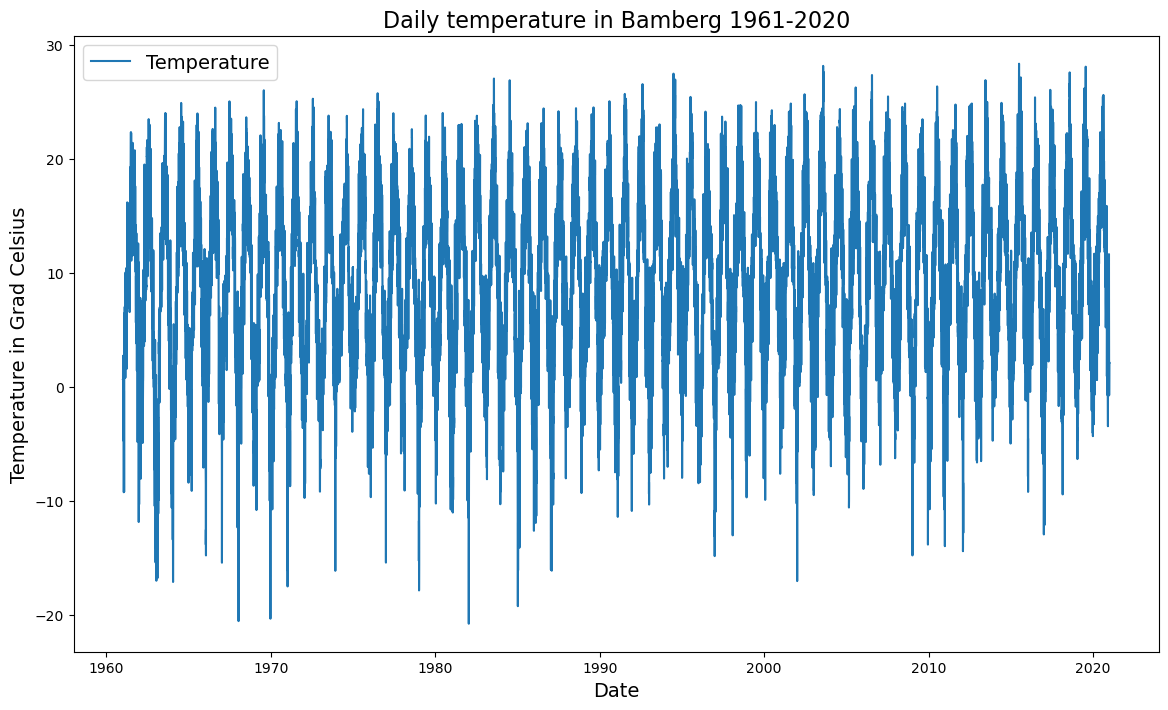

In [20]:
#set the index of 'daily_avg' to the 'MESS_DATUM' column
daily_avg.set_index('MESS_DATUM', inplace=True)

#convert the index to a datetime format
daily_avg.index = pd.to_datetime(daily_avg.index)

#plot the whole dataset
plt.figure(figsize=(14, 8))
plt.plot(daily_avg.index, daily_avg['TT_TU']) 
plt.legend(['Temperature'], fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Temperature in Grad Celsius',fontsize = 14)
plt.title('Daily temperature in Bamberg 1961-2020', fontsize = 16)

plt.show()

In [28]:
#save the information as a .csv file for the following analysis
daily_avg.to_csv('Temperature/daily_temperature_Bamberg.csv',index=True)

Decomposition

Create a decomposition of the daily average temperature signal to display its components: trend, seasonality, and residuals.

In [22]:
#optional
#daily_avg = pd.read_csv('Temperature/daily_temperature_Bamberg.csv', index_col=0, parse_dates=True)
#daily_avg.head()

In [23]:
#impute missing values using interpolate method
missing_values = daily_avg['TT_TU'].isna() 
#Count missing values per column
missing_count = missing_values.sum()
if missing_count >=1: #if we have
    daily_avg['TT_TU'].interpolate(inplace=True)

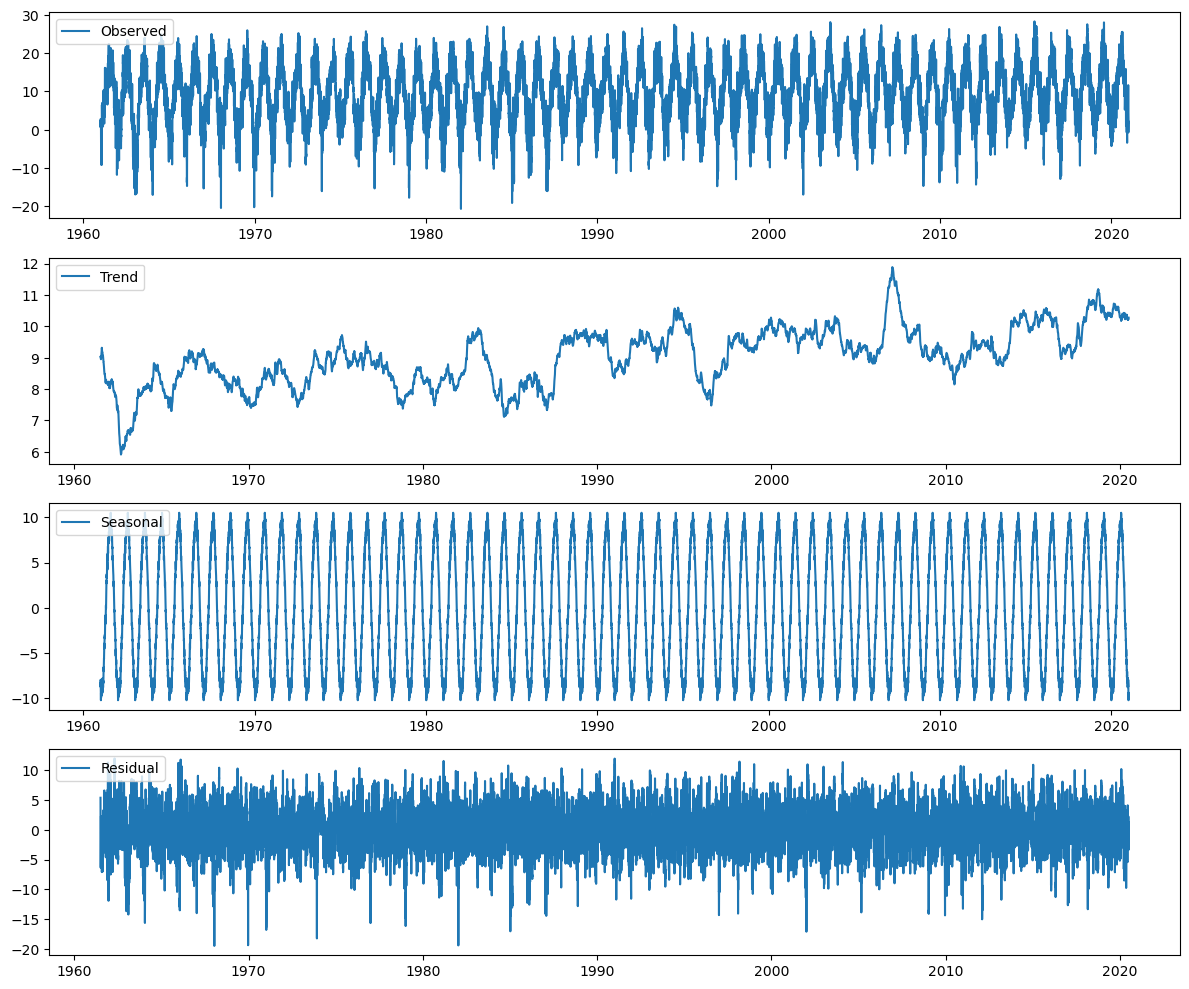

In [25]:
#perform seasonal decomposition with additive model
result = seasonal_decompose(daily_avg['TT_TU'], model='additive', period=365)  #additive model

#for multiplicative model
#add a constant offset to make data non-negative
#offset = abs(min(daily_avg['TT_TU'])) + 1
#daily_avg['adjusted_TT'] = daily_avg['TT_TU'] + offset
#perform seasonal decomposition with multiplicative model
#result = seasonal_decompose(daily_avg['adjusted_TT'], model='multiplicative', period=365)  # Adjust the period as needed

#plot the decomposed components
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Split into decade.

Split the 'daily_temperature_Bamberg.csv' signal into decade periods.

In [31]:
def filter_and_save_dataframe(dataframe, start_year, end_year):
    """
    Filters a DataFrame based on the 'YEAR' column within the specified year range and saves the result to a CSV file.

    :param dataframe: The input DataFrame.
    :param start_year: The starting year.
    :param end_year: The ending year (exclusive).
    :param output_csv_filename: The name of the CSV file to save the result.
    """
    output_csv_filename = f'Temperature/daily_temperature_Bamberg_{start_year}-{end_year-1}.csv'
    condition = (dataframe['Year'] >= start_year) & (dataframe['Year'] < end_year)
    filtered_df = dataframe.loc[condition]
    filtered_df = filtered_df.drop(['Year'],axis=1)
    filtered_df.to_csv(output_csv_filename, index=False)

In [30]:
#read the daily temperature data
df = pd.read_csv('Temperature/daily_temperature_Bamberg.csv')

#convert the 'MESS_DATUM' column to datetime format
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'])

#extract the year information from the 'MESS_DATUM' column
df['Year'] = df['MESS_DATUM'].dt.year
df.head()

MESS_DATUM  TT_TU  Year
0 1961-01-01   0.67  1961
1 1961-01-02   0.68  1961
2 1961-01-03   2.73  1961
3 1961-01-04   2.01  1961
4 1961-01-05   2.64  1961

In [32]:
#split into decades
for i in range(1961, 2020, 10):
    start_year, end_year = i, i+10
    print(start_year, end_year)
    filter_and_save_dataframe(df, start_year, end_year)

1961 1971
1971 1981
1981 1991
1991 2001
2001 2011
2011 2021


Split the data into training and test datasets for the TadGAN method.

In [148]:
#read the daily temperature data
df = pd.read_csv('Temperature/daily_temperature_Bamberg.csv')

#convert the 'MESS_DATUM' column to datetime format
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'])

#extract the year information from the 'MESS_DATUM' column
df['Year'] = df['MESS_DATUM'].dt.year
df.head()

MESS_DATUM  TT_TU  Year
0 1961-01-01   0.67  1961
1 1961-01-02   0.68  1961
2 1961-01-03   2.73  1961
3 1961-01-04   2.01  1961
4 1961-01-05   2.64  1961

In [33]:
#filter data for a training dataset
condition = (df['Year'] >= 1981) & (df['Year'] <= 2000)
df_train = df.loc[condition]
df_train = df_train.drop(['Year'],axis=1)
df_train.head()

MESS_DATUM  TT_TU
7305 1981-01-01   1.80
7306 1981-01-02   1.50
7307 1981-01-03   5.33
7308 1981-01-04   3.46
7309 1981-01-05   0.27

In [34]:
#print a summary of training dataset
df_train.describe()

TT_TU
count  7305.000000
mean      9.027247
std       7.733454
min     -20.770000
25%       3.240000
50%       9.320000
75%      15.160000
max      27.470000

In [35]:
#save the signal as .csv file
df_train['MESS_DATUM'] = df_train['MESS_DATUM'].dt.strftime('%Y%m%d')
df_train.to_csv('Temperature/daily_temperature_training.csv',index=False)

In [36]:
#filter data for a test1 dataset
condition = (df['Year'] >= 1961) & (df['Year'] <= 1980)
df_test1 = df.loc[condition]
df_test1 = df_test1.drop(['Year'],axis=1)
df_test1.head()

MESS_DATUM  TT_TU
0 1961-01-01   0.67
1 1961-01-02   0.68
2 1961-01-03   2.73
3 1961-01-04   2.01
4 1961-01-05   2.64

In [37]:
#print a summary of test1 dataset
df_test1.describe()

TT_TU
count  7305.000000
mean      8.325882
std       7.655059
min     -20.540000
25%       2.600000
50%       8.570000
75%      14.480000
max      26.010000

In [38]:
#save the signal as .csv file
df_test1['MESS_DATUM'] = df_test1['MESS_DATUM'].dt.strftime('%Y%m%d')
df_test1.to_csv('Temperature/daily_temperature_test1.csv',index=False)

In [39]:
#filter data for a test2 dataset
condition = (df['Year'] >= 2001) & (df['Year'] <= 2020)
df_test2 = df.loc[condition]
df_test2 = df_test2.drop(['Year'],axis=1)
df_test2.head()

MESS_DATUM  TT_TU
14610 2001-01-01  -3.29
14611 2001-01-02   2.86
14612 2001-01-03   3.30
14613 2001-01-04   2.02
14614 2001-01-05   4.65

In [40]:
#print a summary of test2 dataset
df_test2.describe()

TT_TU
count  7302.000000
mean      9.734323
std       7.593744
min     -17.030000
25%       3.862500
50%       9.880000
75%      15.737500
max      28.340000

In [41]:
#save the signal as .csv file
df_test2['MESS_DATUM'] = df_test2['MESS_DATUM'].dt.strftime('%Y%m%d')
df_test2.to_csv('Temperature/daily_temperature_test2.csv',index=False)

## Create summary plots for decade signals from the Temperature collection.
This section includes plots with rolling means for each signal, as well as ACF and PACF plots for checking stationarity.

In [43]:
def plot_rolling_statistics(df, file_name, window=12):
    """
    Plots the rolling statistics of a time series, including the original data and the rolling mean.

    Parameters:
    - df (DataFrame): The DataFrame containing the time series data.
    - file_name (str): A string representing the name or description of the data for the plot title.
    - window (int, optional): The window size for calculating the rolling mean. Default is set to 12.
    """

    series = df['TT_TU']
    #plot rolling mean
    rolling_mean = series.rolling(window=window).mean()
    #rolling_std = series.rolling(window=window).std()

    plt.figure(figsize=(16, 10))
    plt.plot(series, label='Temperature')
    plt.plot(rolling_mean, label='Rolling Mean')
    #plt.plot(rolling_std, label='Rolling Std')
    plt.xlabel('Date', fontsize = 14)
    plt.ylabel('Temperature in Grad Celsius',fontsize = 14)
    plt.title(f'Rolling Mean {file_name}', fontsize = 16)
    plt.legend()
    plt.show()

# Function to plot ACF and PACF
def plot_acf_pacf(series,file_name):
    """
    Plots the AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF) of a time series.

    Parameters:
    - series (Series): A pandas Series containing the time series data.
    - file_name (str): A string representing the name or description of the data for the plot titles.
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(series, ax=plt.gca(), lags=None)  # Automatically determine the number of lags
    plt.title(f'ACF {file_name}', fontsize = 16)

    plt.subplot(122)
    plot_pacf(series, ax=plt.gca(), lags=None) # Automatically determine the number of lags
    plt.title(f'PACF {file_name}', fontsize = 16)
    plt.tight_layout()
    plt.show()

#Augmented Dickey Fuller unit root for time series Stationarity. 
#After the changeing of regression parameter we can test different types of stationarity
#c - constant only
#ct - constant and trend
#ctt - constant and quadratic trend
#n - no constant, no trend
def adf_test(series, reg ='c'):
    """
    Performs the Augmented Dickey-Fuller (ADF) test for stationarity.

    Parameters:
    - series (array-like): The time series data to be tested for stationarity.
    - reg (str, optional): The type of regression used in the ADF test. 'c' (default) indicates stationary around a constant.
                           'ct' indicates stationary around a constant and trend.

    Returns:
    - AD_Test (tuple): A tuple containing the ADF test results including the ADF statistic, p-value, number of lags, and critical values.
    """


    #series = df.loc[:, 'value'].values
    AD_Test = adfuller(series, regression=reg, autolag='AIC')
    return AD_Test

# Function to print core information from Augmented Dickey Fuller Test
def print_adf_results(AD_Test):
    """
    Prints the core information obtained from the Augmented Dickey-Fuller (ADF) test.

    Parameters:
    - AD_Test (tuple): A tuple containing the ADF test results.

    """
    print(f'ADF Statistic: {AD_Test[0]}')
    print(f'p-value: {AD_Test[1]}')
    print(f'n_lags: {AD_Test[2]}')
    print(f'Number of observations:{AD_Test[3]}')
    for key, value in AD_Test[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

#Kwiatkowski Phillips Schmidt Test
#After the changeing of Regressions parameter we can test different types of stationarity
#c - data is stationary around constant
#ct - data is stationary around constant and trend
def kpss_test(series,reg = 'c'):
    """
    Performs the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity.

    Parameters:
    - series (array-like): The time series data to be tested for stationarity.
    - reg (str, optional): The type of regression used in the KPSS test. 'c' (default) indicates stationary around a constant.
                          'ct' indicates stationary around a constant and trend.

    Returns:
    - KPSS_test (tuple): A tuple containing the KPSS test results including the KPSS statistic, p-value, number of lags, and critical values.
    """

    #series = df.loc[:, 'value'].values
    KPSS_test = kpss(series, regression=reg)
    return KPSS_test


#Function to print the core information from Kwiatkowski Phillips Schmidt Test
def print_kpss_results(KPSS_test):
    """
    Prints the core information obtained from the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.

    Parameters:
    - KPSS_test (tuple): A tuple containing the KPSS test results.

    """
    print(f'KPSS Statistic: {KPSS_test[0]}')
    print(f'p-value: {KPSS_test[1]}')
    print(f'n_lags: {KPSS_test[2]}')
    for key, value in KPSS_test[3].items():
        print('Critial Values:')
        print(f'   {key}, {value}')  

def print_information_about_file(df, file_name):
    """
    Prints information about a time series dataset including rolling statistics, ADF test results, KPSS test results, and ACF/PACF plots.

    Parameters:
    - df (DataFrame): The DataFrame containing the time series data.
    - file_name (str): A string representing the name or description of the data for the printed information.
    """
    print(f'information about: {file_name}')
    # Extract the series values
    series = df.loc[:, 'TT_TU'].values
    plot_rolling_statistics(df,file_name)
    # Perform Tests
    AD_Test = adf_test(series)
    KPSS_test = kpss_test(series)
    # Print ADF test results
    print_adf_results(AD_Test)
    print_kpss_results(KPSS_test)
    # Plot ACF and PACF
    plot_acf_pacf(series,file_name)



information about: daily_temperature_Bamberg_1981-1990.csv
             TT_TU
count  3652.000000
mean      8.726377
std       7.825546
min     -20.770000
25%       2.787500
50%       9.175000
75%      14.942500
max      27.040000


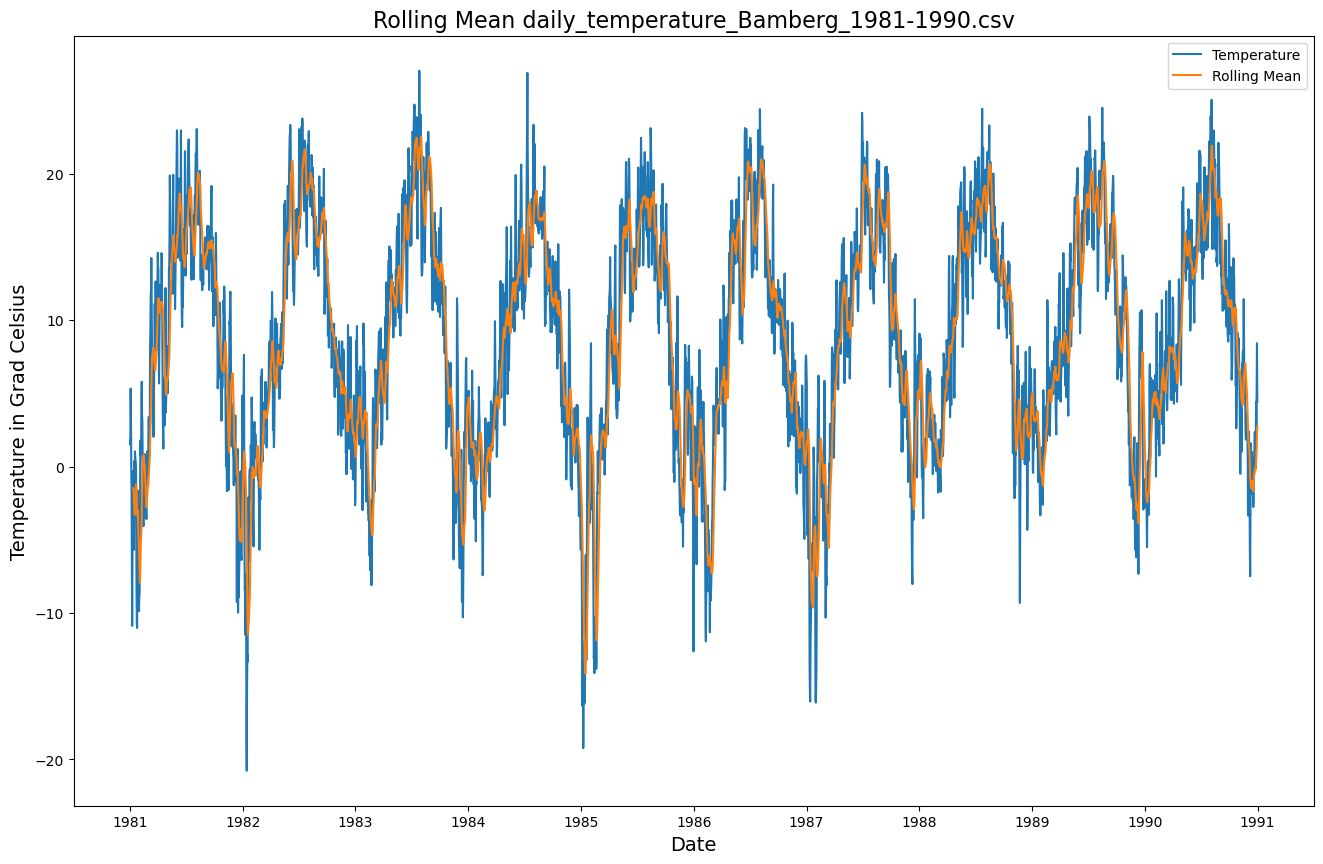

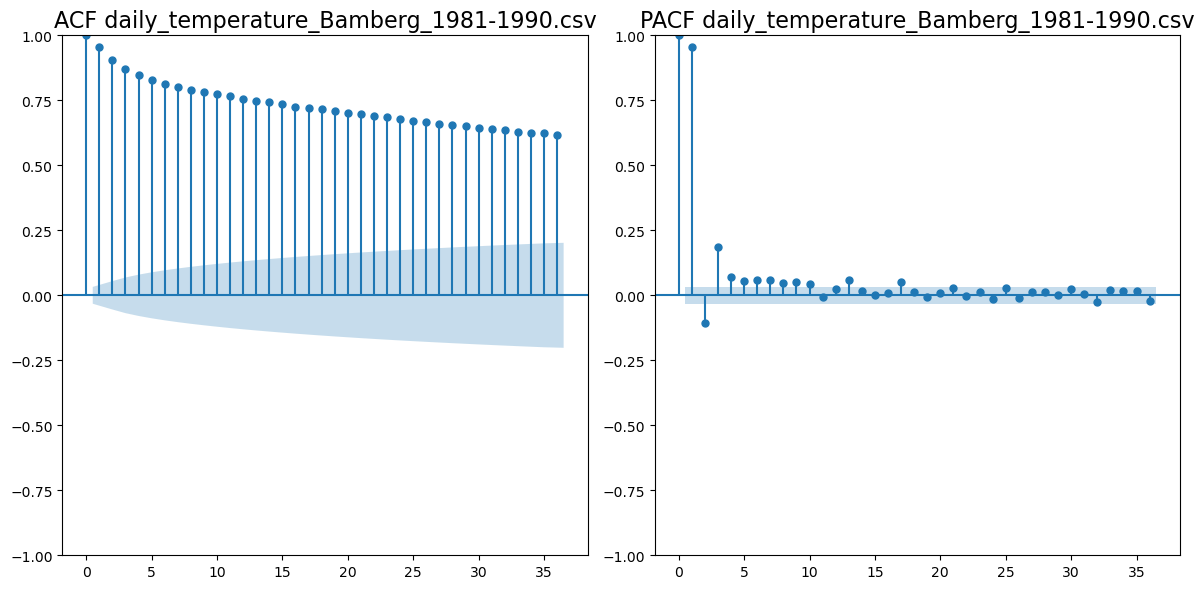

information about: daily_temperature_Bamberg_1961-1970.csv
             TT_TU
count  3652.000000
mean      8.178395
std       7.970191
min     -20.540000
25%       2.157500
50%       8.945000
75%      14.482500
max      26.010000


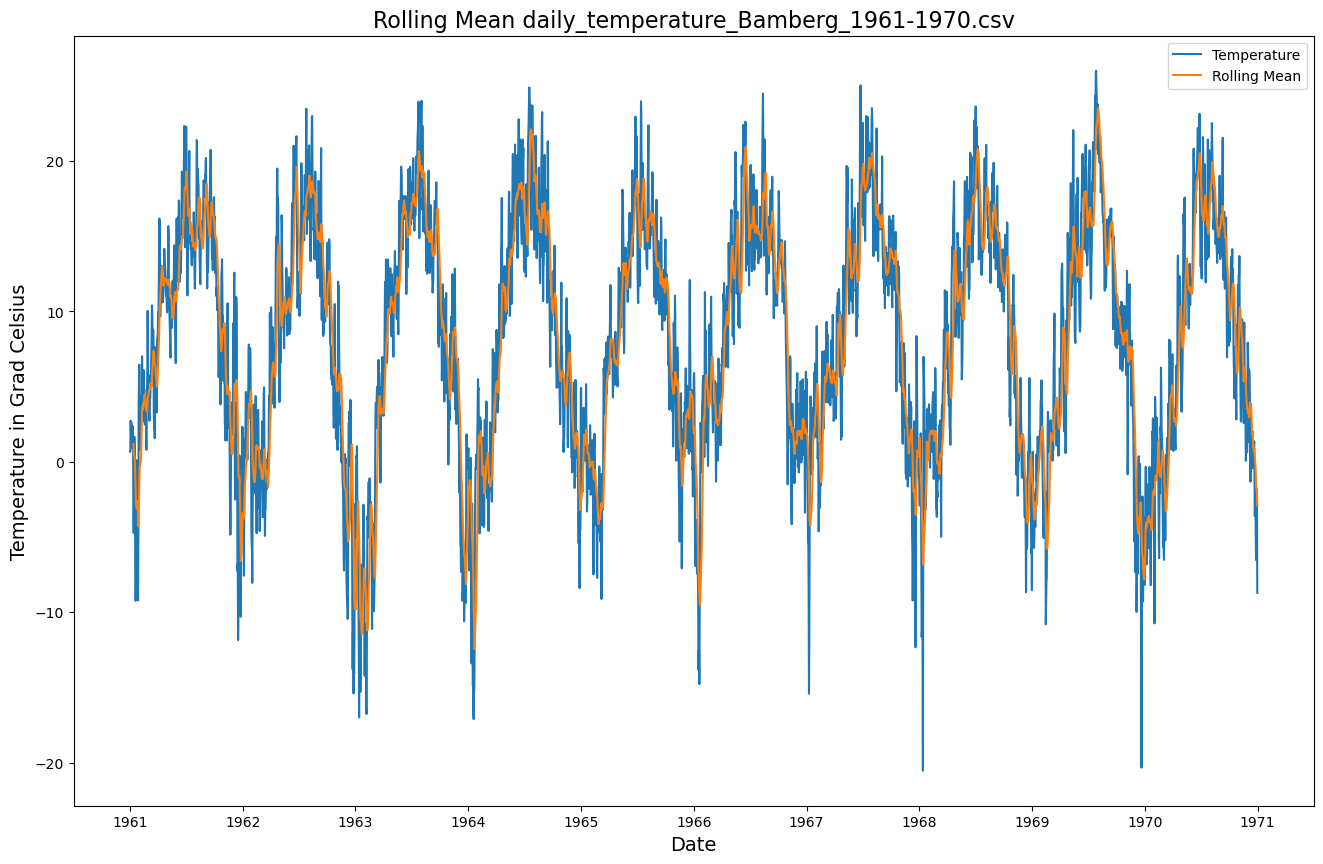

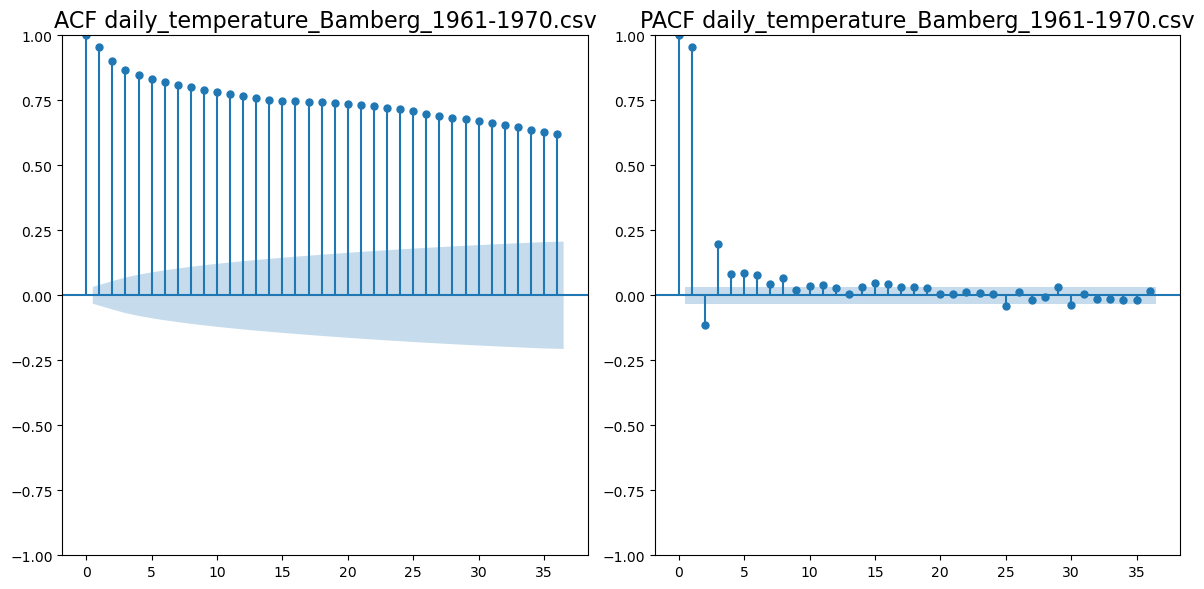

information about: daily_temperature_Bamberg_2011-2020.csv
             TT_TU
count  3650.000000
mean      9.919795
std       7.338725
min     -14.410000
25%       4.110000
50%       9.830000
75%      15.735000
max      28.340000


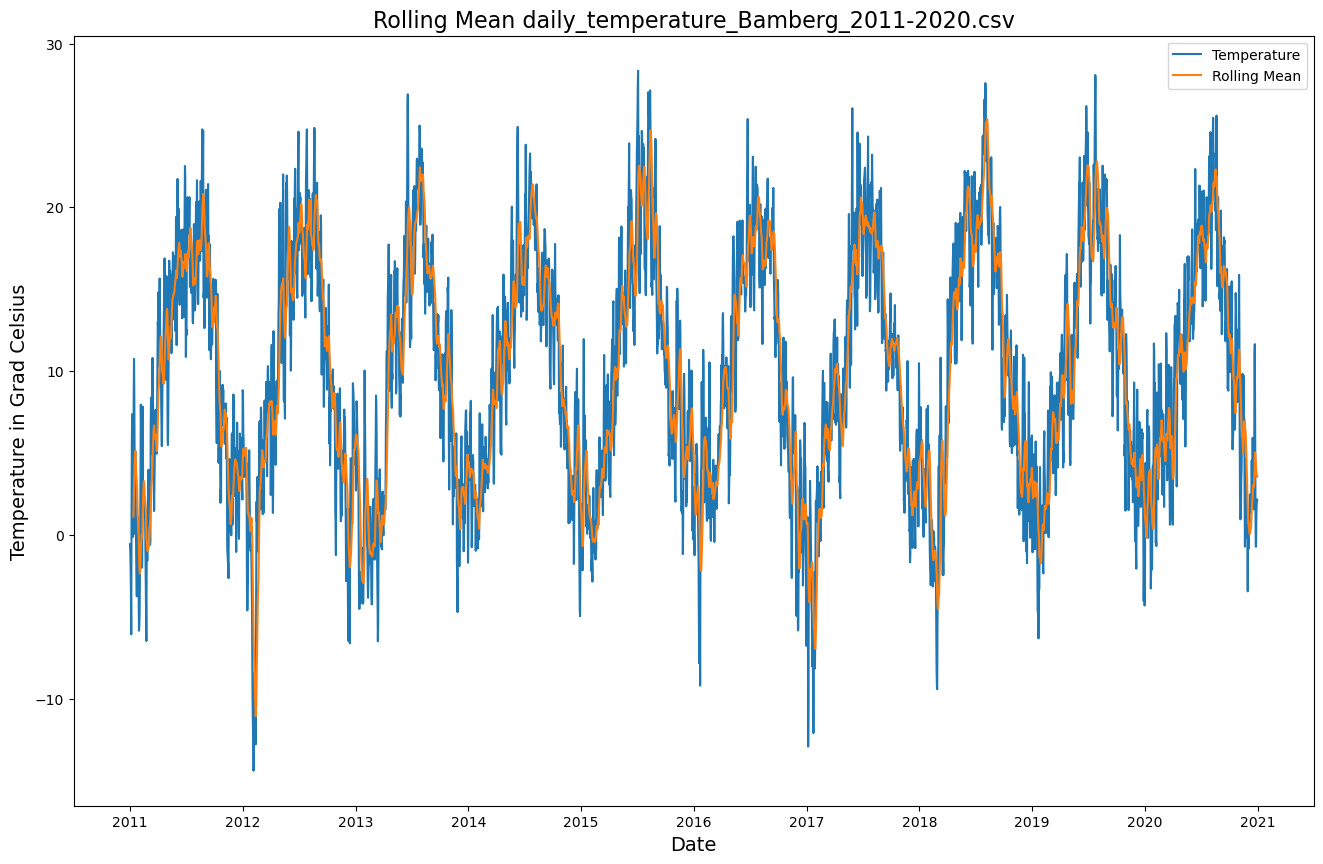

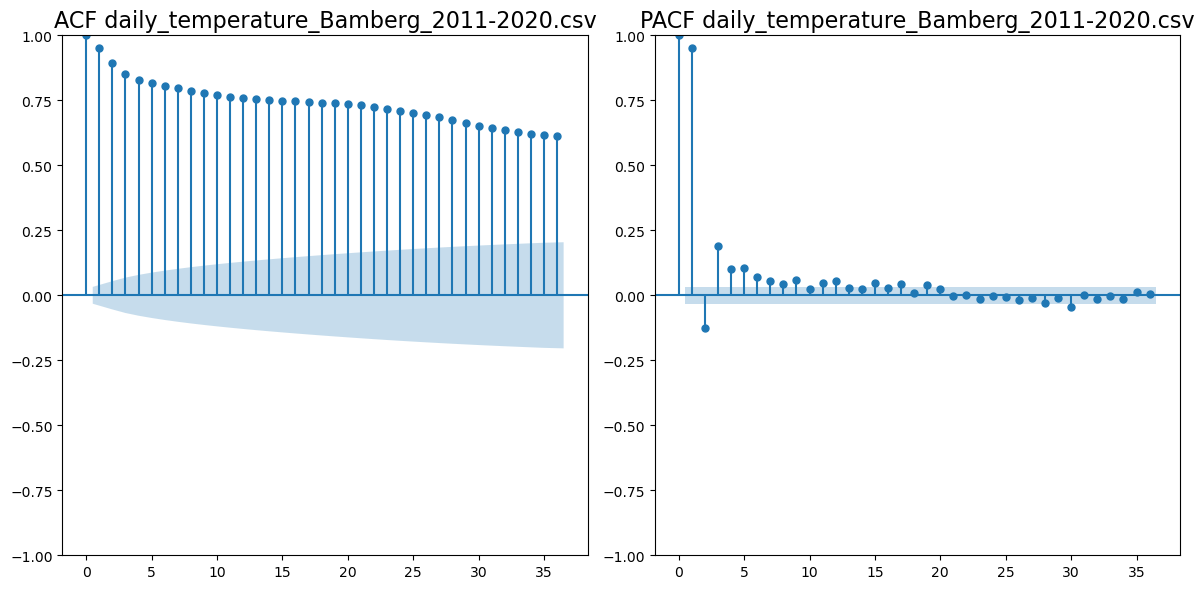

information about: daily_temperature_Bamberg_2001-2010.csv
             TT_TU
count  3652.000000
mean      9.548954
std       7.836960
min     -17.030000
25%       3.547500
50%       9.920000
75%      15.732500
max      28.150000


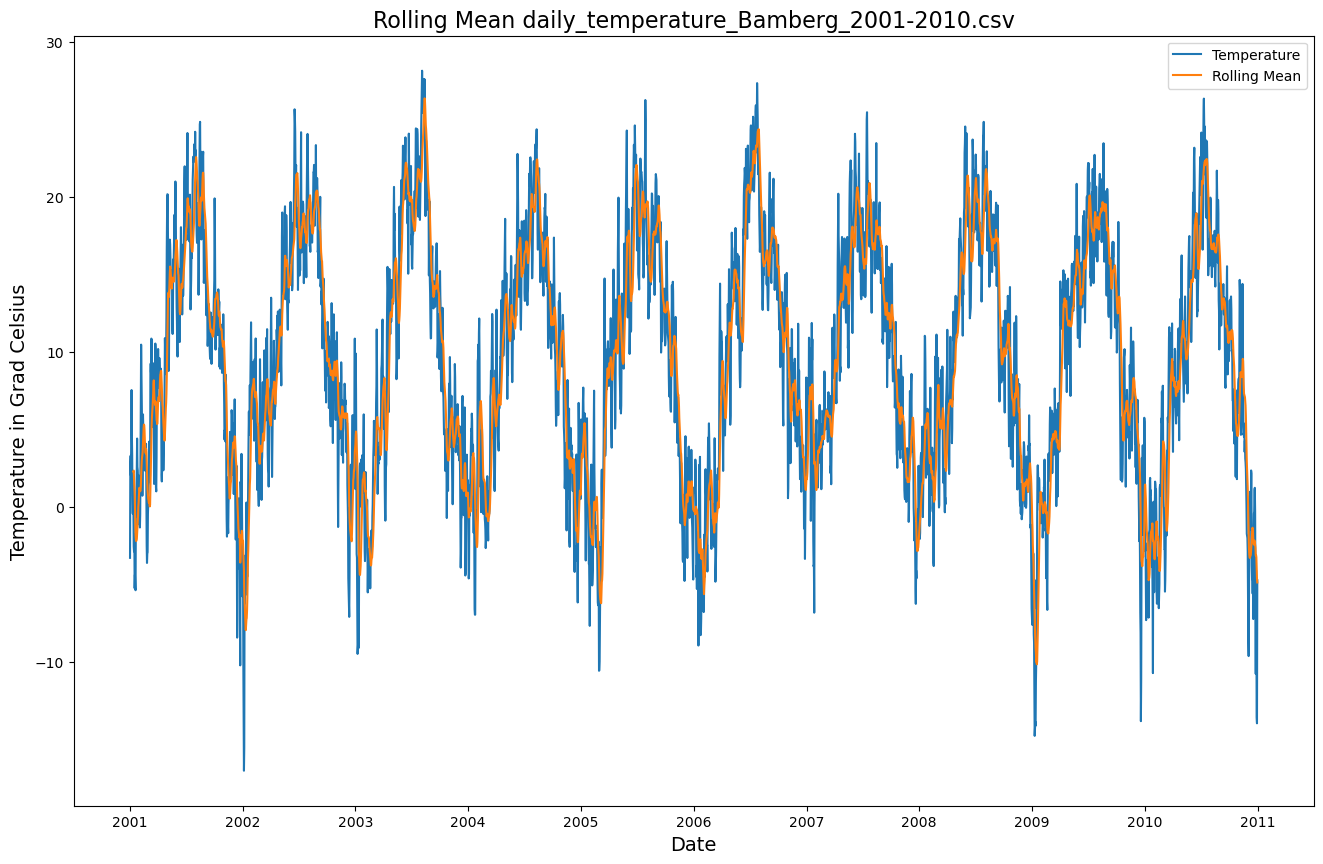

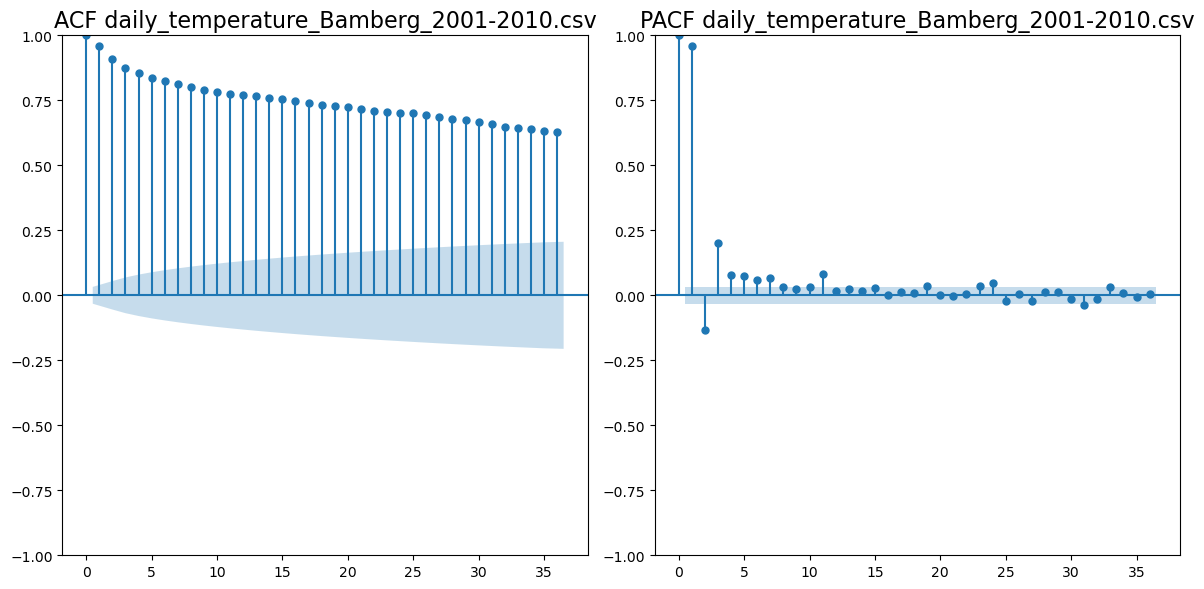

information about: daily_temperature_Bamberg_1971-1980.csv
             TT_TU
count  3653.000000
mean      8.473329
std       7.324602
min     -17.850000
25%       2.870000
50%       8.140000
75%      14.470000
max      25.750000


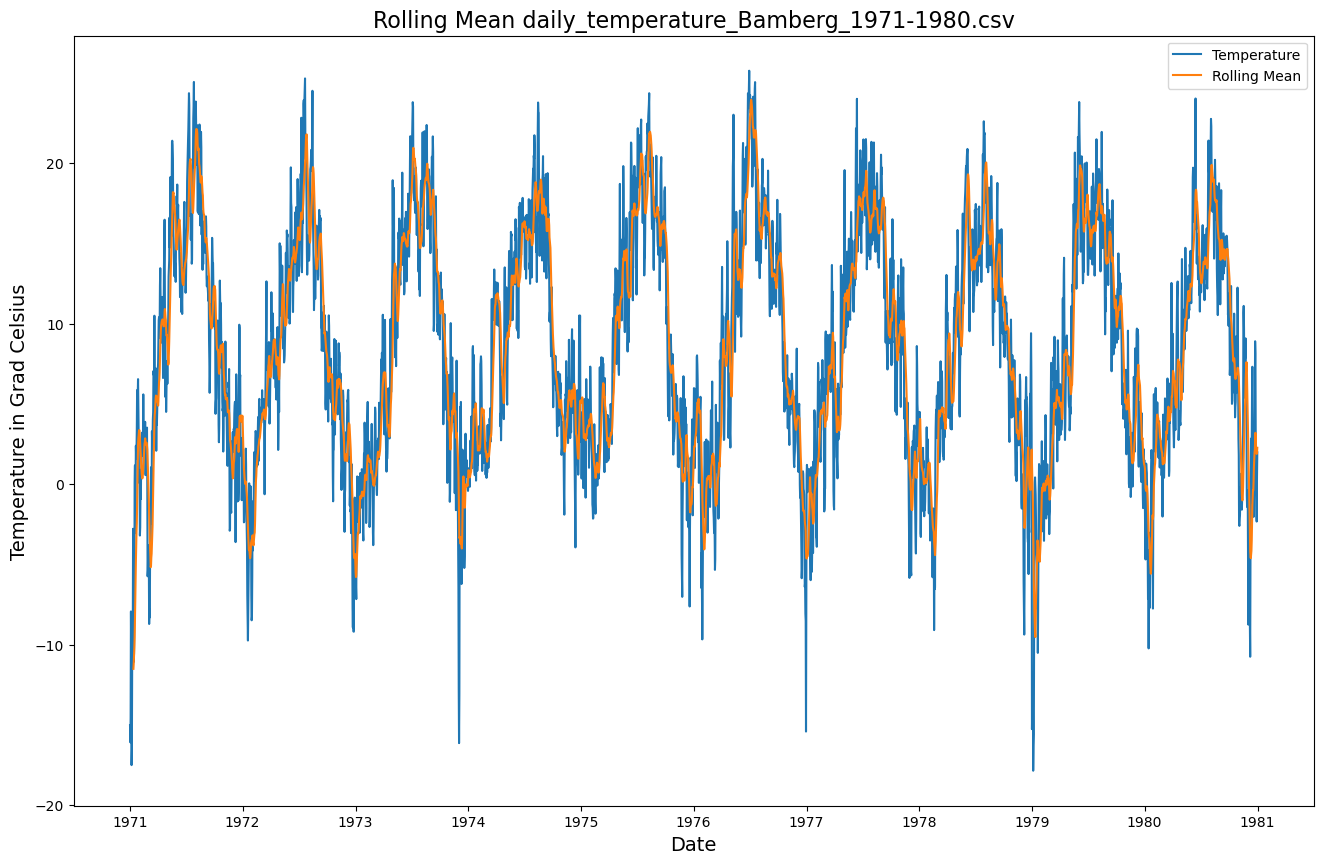

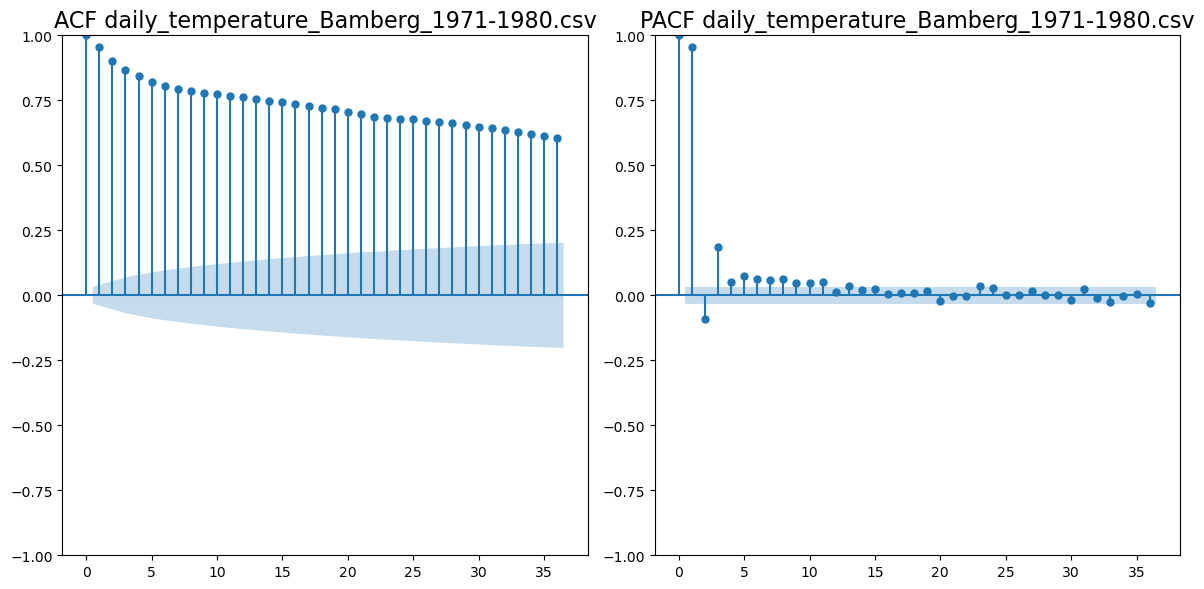

information about: daily_temperature_Bamberg_1991-2000.csv
             TT_TU
count  3653.000000
mean      9.328034
std       7.629494
min     -14.840000
25%       3.610000
50%       9.470000
75%      15.450000
max      27.470000


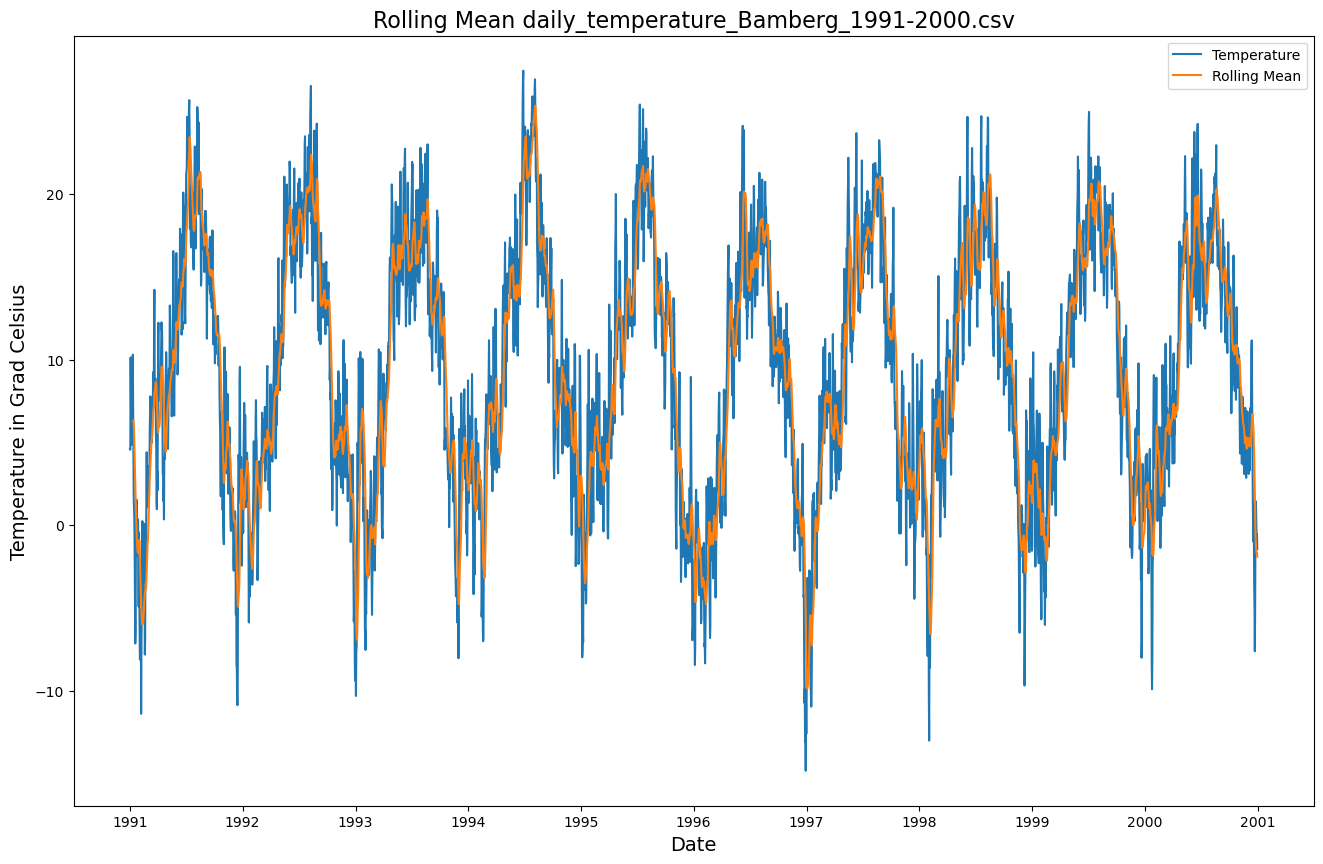

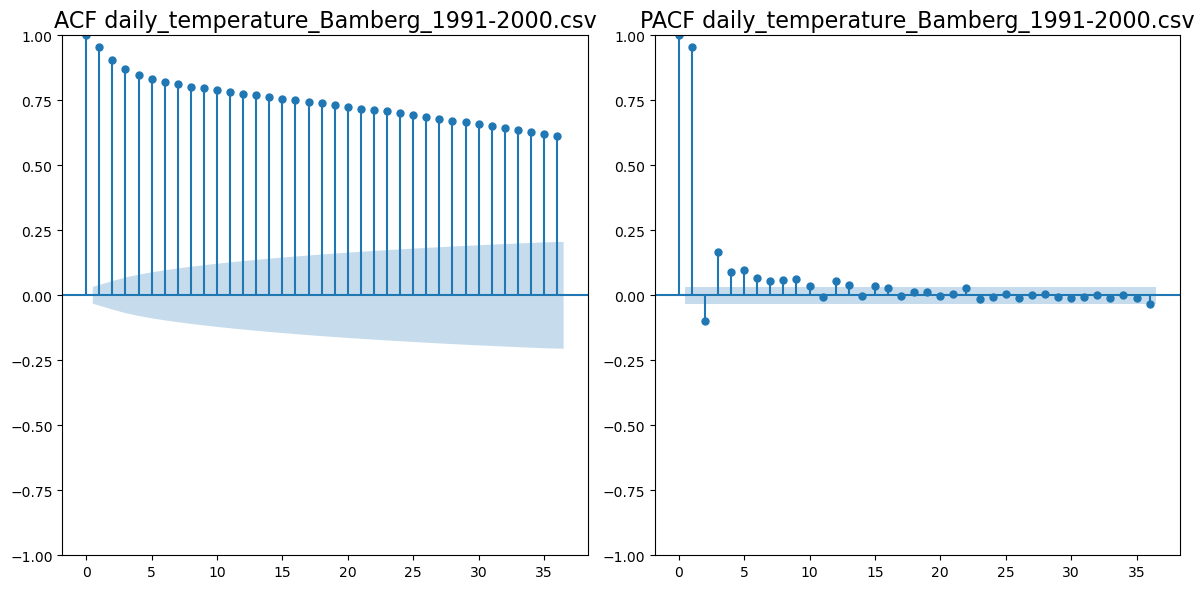

In [46]:
#become file lists
csv_files = glob.glob('Temperature/daily_temperature_Bamberg_*.csv')
file_names = [os.path.basename(file) for file in csv_files]

for file_name in file_names:
    df = pd.read_csv(f'Temperature/{file_name}', index_col=0, parse_dates=True)
    print(f'information about: {file_name}')
    print(df.describe())
    #extract the series values
    series = df.loc[:, 'TT_TU'].values
    plot_rolling_statistics(df,file_name)
    # Perform Tests
    #AD_Test = adf_test(series)
    #KPSS_test = kpss_test(series)
    # Print ADF test results
    #print_adf_results(AD_Test)
    #print_kpss_results(KPSS_test)
    # Plot ACF and PACF
    plot_acf_pacf(series,file_name)

information about: daily_temperature_Bamberg_1981-1990.csv
             TT_TU
count  3652.000000
mean      8.726377
std       7.825546
min     -20.770000
25%       2.787500
50%       9.175000
75%      14.942500
max      27.040000


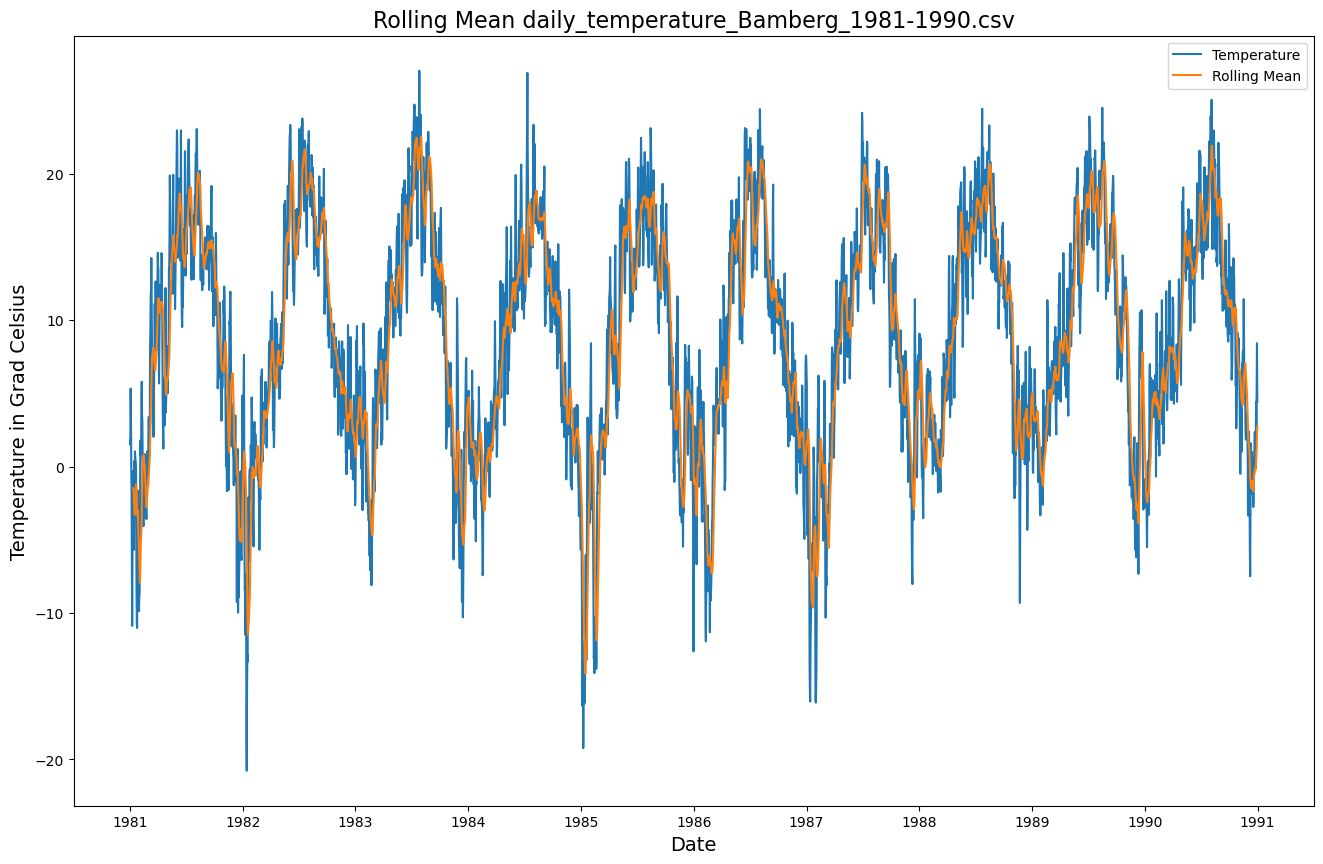

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_4564/3410744297.py:105: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -4.408536523873842
p-value: 0.00028667543028363507
n_lags: 16
Number of observations:3635
Critical Values:
   1%, -3.432150254165979
Critical Values:
   5%, -2.8623354519441797
Critical Values:
   10%, -2.567193431297053
KPSS Statistic: 0.0754205589108631
p-value: 0.1
n_lags: 37
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


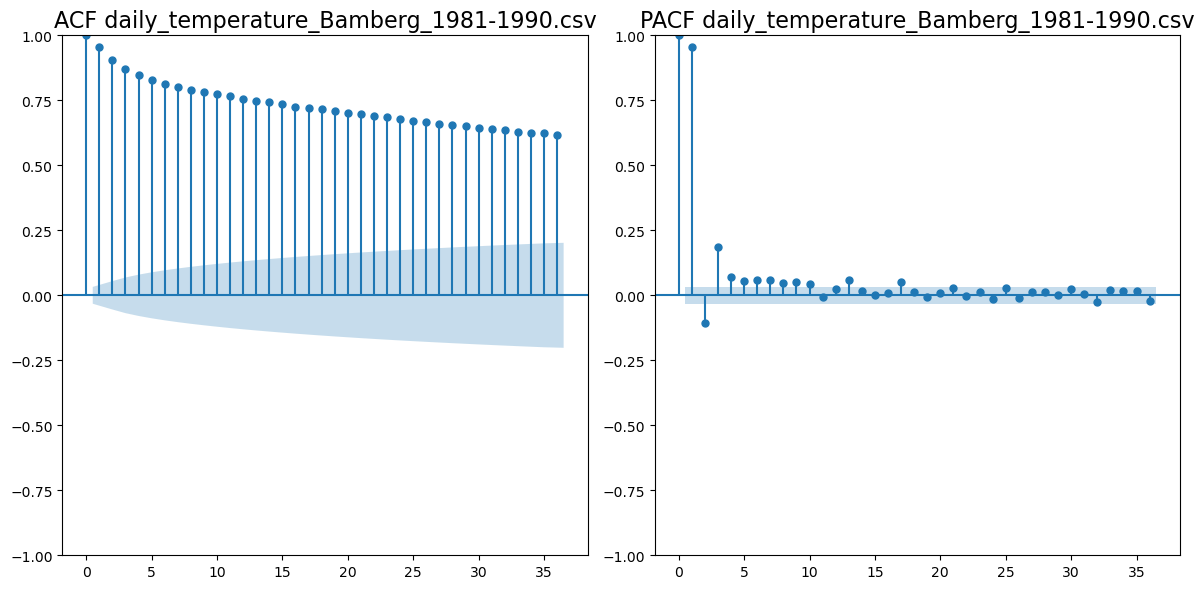

information about: daily_temperature_Bamberg_1961-1970.csv
             TT_TU
count  3652.000000
mean      8.178395
std       7.970191
min     -20.540000
25%       2.157500
50%       8.945000
75%      14.482500
max      26.010000


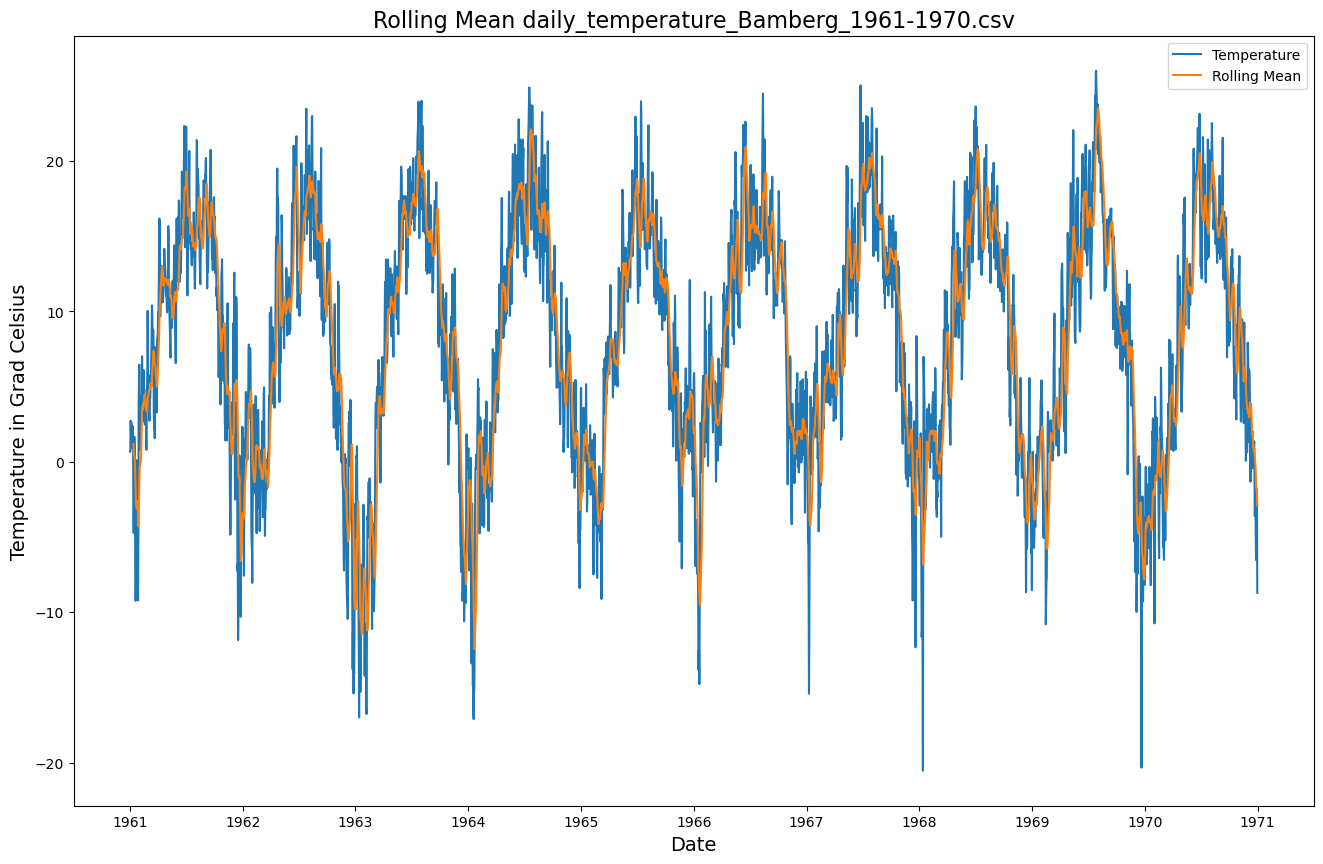

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_4564/3410744297.py:105: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -3.691032061950976
p-value: 0.004241079163744021
n_lags: 18
Number of observations:3633
Critical Values:
   1%, -3.4321512459240684
Critical Values:
   5%, -2.862335890025229
Critical Values:
   10%, -2.5671936645169833
KPSS Statistic: 0.04346918501152263
p-value: 0.1
n_lags: 37
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


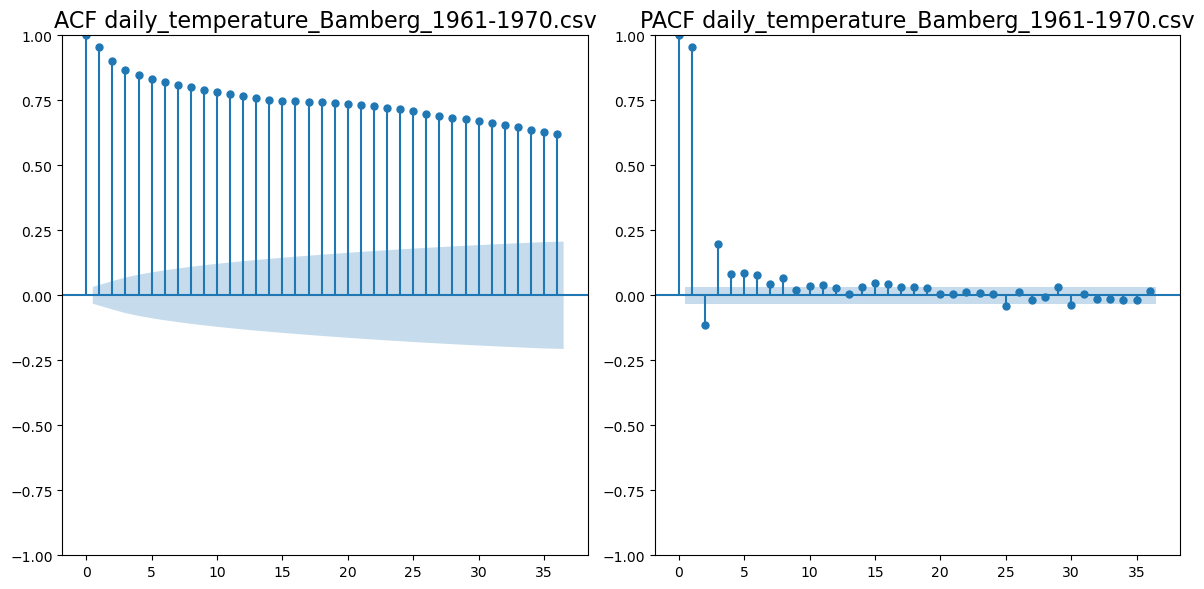

information about: daily_temperature_Bamberg_2011-2020.csv
             TT_TU
count  3650.000000
mean      9.919795
std       7.338725
min     -14.410000
25%       4.110000
50%       9.830000
75%      15.735000
max      28.340000


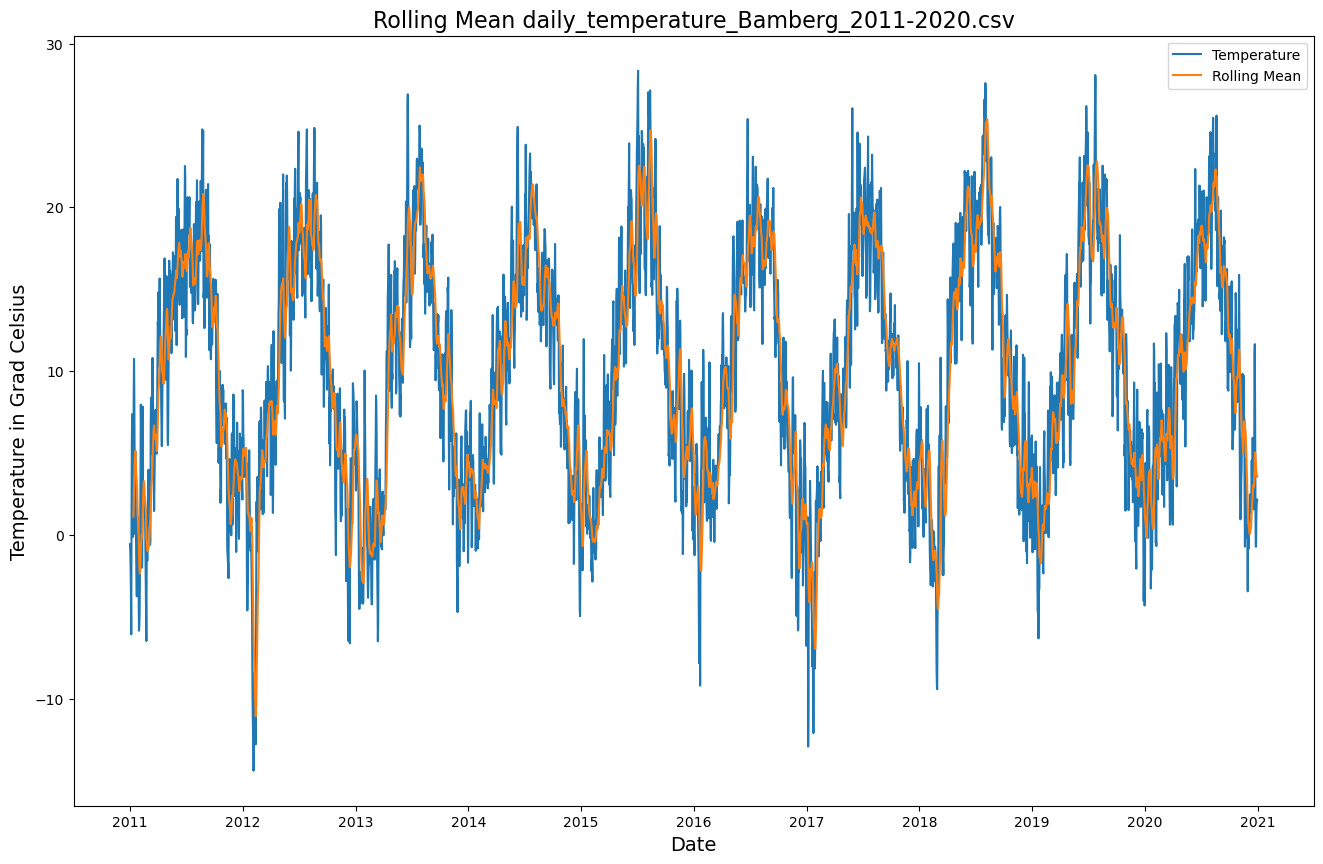

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_4564/3410744297.py:105: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -3.574428453163948
p-value: 0.006269145542678526
n_lags: 19
Number of observations:3630
Critical Values:
   1%, -3.432152735611742
Critical Values:
   5%, -2.8623365480522964
Critical Values:
   10%, -2.567194014828981
KPSS Statistic: 0.06714355376738312
p-value: 0.1
n_lags: 37
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


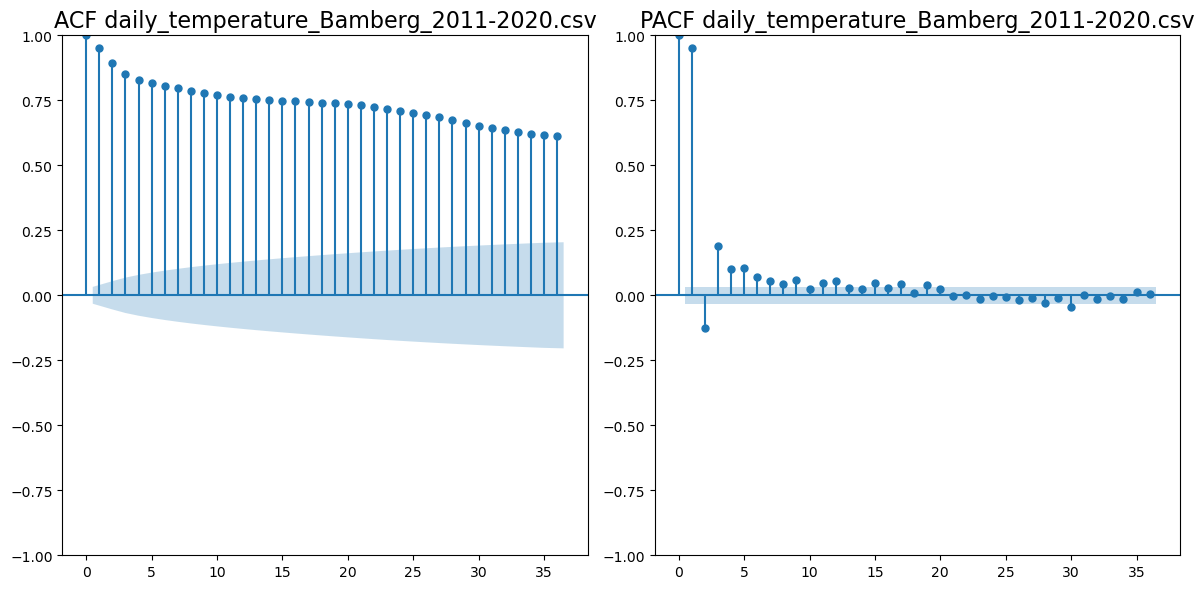

information about: daily_temperature_Bamberg_2001-2010.csv
             TT_TU
count  3652.000000
mean      9.548954
std       7.836960
min     -17.030000
25%       3.547500
50%       9.920000
75%      15.732500
max      28.150000


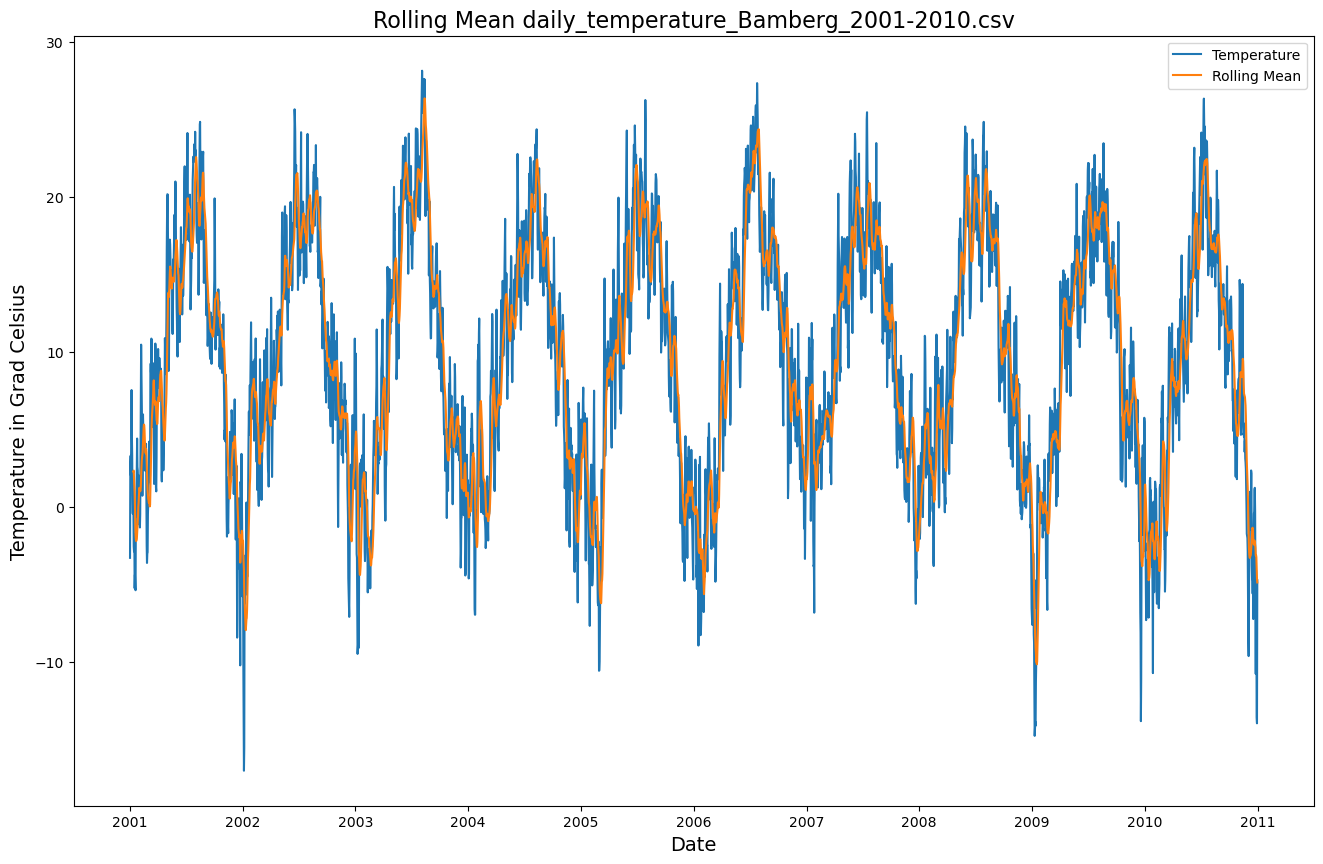

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_4564/3410744297.py:105: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -3.4214324293573877
p-value: 0.010249582171920568
n_lags: 23
Number of observations:3628
Critical Values:
   1%, -3.432153730106524
Critical Values:
   5%, -2.8623369873418363
Critical Values:
   10%, -2.567194248692334
KPSS Statistic: 0.03372776617321193
p-value: 0.1
n_lags: 37
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


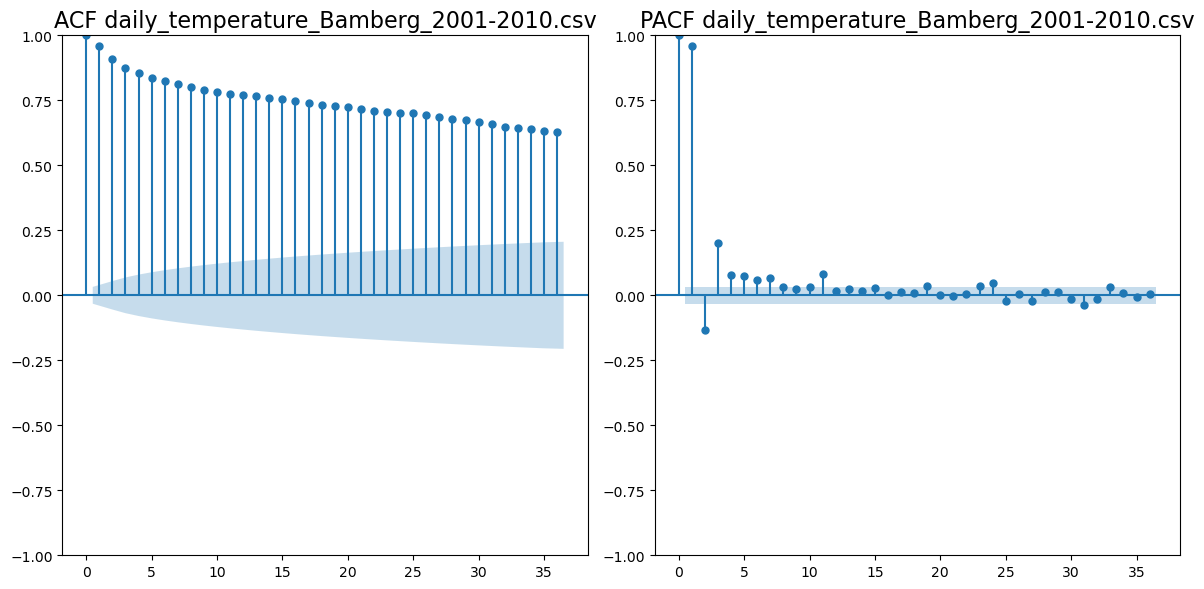

information about: daily_temperature_Bamberg_1971-1980.csv
             TT_TU
count  3653.000000
mean      8.473329
std       7.324602
min     -17.850000
25%       2.870000
50%       8.140000
75%      14.470000
max      25.750000


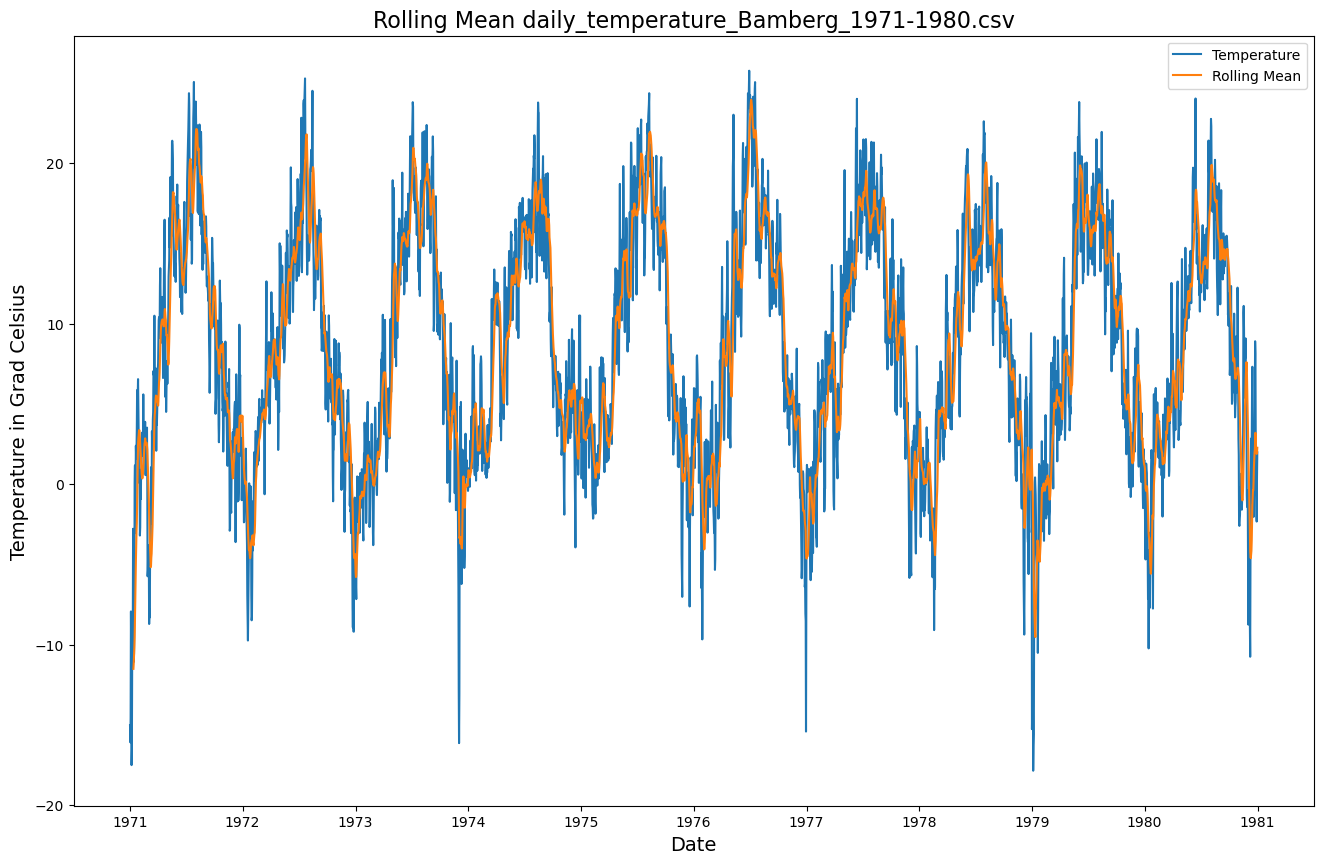

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_4564/3410744297.py:105: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -4.626039208424445
p-value: 0.00011562312580725506
n_lags: 14
Number of observations:3638
Critical Values:
   1%, -3.432148768574872
Critical Values:
   5%, -2.862334795726108
Critical Values:
   10%, -2.5671930819481976
KPSS Statistic: 0.03489598643840635
p-value: 0.1
n_lags: 37
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


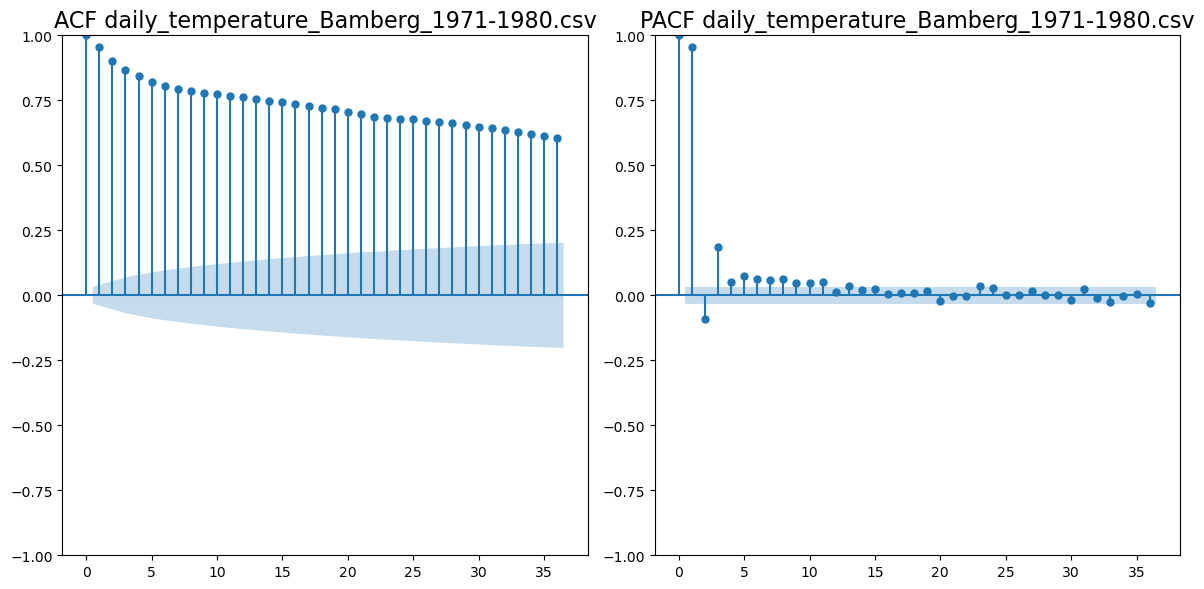

information about: daily_temperature_Bamberg_1991-2000.csv
             TT_TU
count  3653.000000
mean      9.328034
std       7.629494
min     -14.840000
25%       3.610000
50%       9.470000
75%      15.450000
max      27.470000


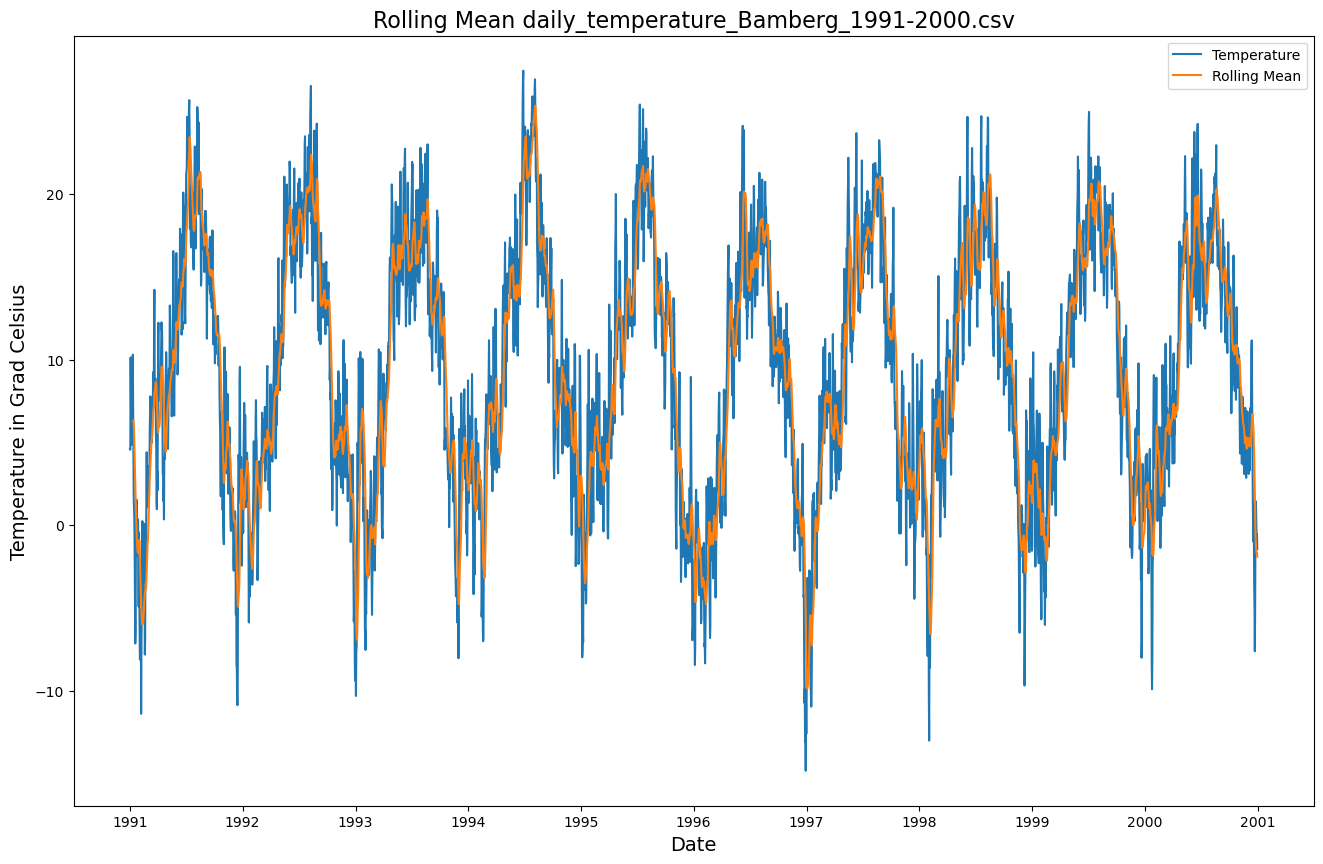

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_4564/3410744297.py:105: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -4.060739401767551
p-value: 0.0011238141282031195
n_lags: 15
Number of observations:3637
Critical Values:
   1%, -3.432149263499404
Critical Values:
   5%, -2.8623350143451307
Critical Values:
   10%, -2.5671931983337477
KPSS Statistic: 0.045255252239128275
p-value: 0.1
n_lags: 37
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


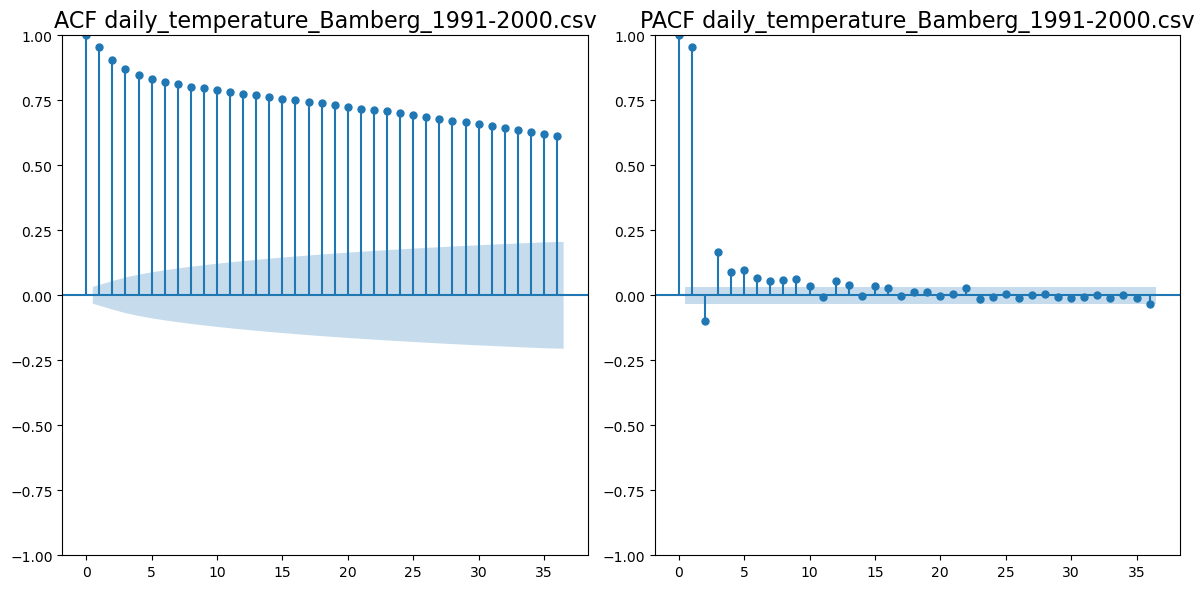

In [47]:
for file_name in file_names:
    df = pd.read_csv(f'Temperature/{file_name}', index_col=0, parse_dates=True)
    #check for missing values
    missing_values = df['TT_TU'].isna() # or df.isnull()
    
    #impute missing value using interpolate method
    missing_count = missing_values.sum()
    if missing_count >=1:
        df['TT_TU'].interpolate(inplace=True)
        
    print(f'information about: {file_name}')
    print(df.describe())
    #extract the series values
    series = df.loc[:, 'TT_TU'].values
    plot_rolling_statistics(df,file_name)
    #perform Tests
    AD_Test = adf_test(series)
    KPSS_test = kpss_test(series)
    #print ADF test results
    print_adf_results(AD_Test)
    print_kpss_results(KPSS_test)
    #plot ACF and PACF
    plot_acf_pacf(series,file_name)
    #print(missing_count)